In [1]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../20240503')
import DCTR


In [2]:
def get_wgt_from_lhe(lhe_file, limit = None):
    # Use Madgraph EventFile
    from madgraph.various.lhe_parser import EventFile # madgraph EventFile for getting event weights from lhe

    # get event weights from lhe file
    wgt = []
    lhe = EventFile(lhe_file) # uses madgraphs EventFile function to open the lhe file
    if limit is None:
        limit = len(lhe)
    for i, event in enumerate(lhe):
        if i >= limit:
            break
        w = event.wgt
        wgt.append(w)
    
    return wgt


In [3]:
from madgraph.various.lhe_parser import EventFile # madgraph EventFile for getting event weights from lhe

def convert_valentinas_datasets_to_mine(tt_npz_list, top_npz_list, lhe_list, theta):
    '''converts valentinas dataset layout and shape into mine.
    valentinas: tt:  [pt, y, eta, phi, mass, E]
                top: [pt, y, eta, phi, mass, PID]
    mine:            [pt, y, phi, mass, eta, E, PID, w, theta]
                     [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

    args:
        tt_npz_list

    no event weights! We need to load lhe to find event weight.
    '''
    assert len(tt_npz_list) == len(top_npz_list) == len(lhe_list), 'Lengths of lists must be equal!'

    # create mapping from valentinas to mine
    target_order  = ['pt', 'y', 'phi', 'mass', 'eta', 'E', 'PID', 'w', 'theta'] # my order
    org_order_tt  = ['pt', 'y', 'eta', 'phi', 'mass', 'E', 'PID', 'w', 'theta'] # tt org
    org_order_top = ['pt', 'y', 'eta', 'phi', 'mass', 'PID', 'E', 'w', 'theta'] # top org
    mapping_tt = [org_order_tt.index(col) for col in target_order]
    mapping_top = [org_order_top.index(col) for col in target_order]
    
    out = []
    skipped = []
    for i, _ in enumerate(tt_npz_list):
        # check if files exist
        if not os.path.exists(tt_npz_list[i]):
            print(f"file: {tt_npz_list[i]} doesn't exist; skipping")
            skipped.append(i+1)
            continue
        elif not os.path.exists(top_npz_list[i]):
            print(f"file: {top_npz_list[i]} doesn't exist; skipping")
            skipped.append(i+1)
            continue
        elif not os.path.exists(lhe_list[i]):
            print(f"file: {lhe_list[i]} doesn't exist; skipping")
            skipped.append(i+1)
            continue
        
        # get event weights from lhe file
        wgt = []
        lhe = EventFile(lhe_list[i]) # uses madgraphs EventFile function to open the lhe file
        for event in lhe:
            w = event.wgt
            wgt.append(w)
        # print(f'{np.shape(wgt) = }')
        
        # load tt-dataset
        tt = []
        tt = np.load(tt_npz_list[i])['a']
        # print(f'{np.shape(tt) = }')
        
        # load top (and anti-top) dataset
        top = []
        top = np.load(top_npz_list[i])['a']
        # print(f'{np.shape(top) = }')

        # check that lhe file and converted npz contain same number of events
        if len(tt) != len(wgt) != len(top):
            print(f'different number of events in files! \n' + 
                  f'tt : len: {len(tt)} | file: {tt_npz_list[i]} \n' +
                  f'top: len: {len(top)} | file: {top_npz_list[i]} \n' +
                  f'lhe: len: {len(wgt)} | file: {lhe_list[i]} \n' +
                  f'skipping files {i+1}')
            skipped.append(i+1)
            continue
        elif len(wgt) <= 10:
            print(f'file: {lhe_list[i]} only has {len(wgt)} events; skipping')
            skipped.append(i+1)
            continue
        

        # pad arrays into correct final shape
        tt = np.pad(tt, [(0,0), (0,0), (0, 3)])
        top = np.pad(top, [(0,0), (0,0), (0, 3)])   
        # print(f'shape after padding {np.shape(tt) = }')
        # print(f'shape after padding {np.shape(top) = }') 

        # re-sort datasets
        tt = tt[..., mapping_tt] 
        top = top[..., mapping_top]

        # concat to have tt-pair and top and anti-top for each event
        concat = []
        concat = np.concatenate((tt, top), axis=1)
        # print(f'{np.shape(concat) = }')
        
        # add wgt
        wgt = [wgt] * 3 # every particle has same wgt (as it is an event wgt)
        concat[..., 7] = np.transpose(wgt)
        
        # add theta
        theta_ = np.full_like(concat[..., 8], theta)
        concat[..., 8] = theta_
        
        # add to out
        if i == 0:
            out = concat
        else:
            out = np.concatenate((out, concat), axis = 0)
        print(f'finished processing file {i+1:0>4}', end='\r')
    
    return out, skipped


# Process Data

In [4]:
# X0 hvq
'''
X0_tt_npz_list  = ['/tf/data/BachelorThesis_Data/showered/hvq/ShowerTT_100.npz']
X0_top_npz_list = ['/tf/data/BachelorThesis_Data/showered/hvq/ShowerTop_100.npz']
X0_lhe_list     = ['/tf/data/BachelorThesis_Data/LHE/data/POWHEG_new/Results100/pwgevents.lhe']
X0_theta = 0

X0_showered, _ = convert_valentinas_datasets_to_mine(X0_tt_npz_list, X0_top_npz_list, X0_lhe_list, theta = X0_theta)

print(np.shape(X0_showered))
'''

"\nX0_tt_npz_list  = ['/tf/data/BachelorThesis_Data/showered/hvq/ShowerTT_100.npz']\nX0_top_npz_list = ['/tf/data/BachelorThesis_Data/showered/hvq/ShowerTop_100.npz']\nX0_lhe_list     = ['/tf/data/BachelorThesis_Data/LHE/data/POWHEG_new/Results100/pwgevents.lhe']\nX0_theta = 0\n\nX0_showered, _ = convert_valentinas_datasets_to_mine(X0_tt_npz_list, X0_top_npz_list, X0_lhe_list, theta = X0_theta)\n\nprint(np.shape(X0_showered))\n"

In [5]:
# normalize data
'''
data_dir = '../Data'

# nrm_array from previous normalization (of showered events)
nrm_array = np.load(f'{data_dir}/POWHEG_hvq/showered/norm_array_lhe_01.npy')

# normalize data
X0_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)
print('X0 normalized')

# save normalized and unnormalized
np.save(f'{data_dir}/Jets/hvq_Results100_showered_normed_lhe.npy', X0_nrm)
np.save(f'{data_dir}/Jets/hvq_Results100_showered_converted_lhe.npy', X0_showered)
'''

"\ndata_dir = '../Data'\n\n# nrm_array from previous normalization (of showered events)\nnrm_array = np.load(f'{data_dir}/POWHEG_hvq/showered/norm_array_lhe_01.npy')\n\n# normalize data\nX0_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)\nprint('X0 normalized')\n\n# save normalized and unnormalized\nnp.save(f'{data_dir}/Jets/hvq_Results100_showered_normed_lhe.npy', X0_nrm)\nnp.save(f'{data_dir}/Jets/hvq_Results100_showered_converted_lhe.npy', X0_showered)\n"

In [6]:
# X1 MiNNLO
'''
X1_tt_npz_list  = ['/tf/data/BachelorThesis_Data/showered/MiNNLO/ShowerTTR_1000_0.855.npz']
X1_top_npz_list = ['/tf/data/BachelorThesis_Data/showered/MiNNLO/ShowerTopR_1000_0.855.npz']
X1_lhe_list     = ['/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-1000.lhe']
X1_theta = 1

X1_showered, _ = convert_valentinas_datasets_to_mine(X1_tt_npz_list, X1_top_npz_list, X1_lhe_list, theta = X1_theta)

print(np.shape(X1_showered))
'''

"\nX1_tt_npz_list  = ['/tf/data/BachelorThesis_Data/showered/MiNNLO/ShowerTTR_1000_0.855.npz']\nX1_top_npz_list = ['/tf/data/BachelorThesis_Data/showered/MiNNLO/ShowerTopR_1000_0.855.npz']\nX1_lhe_list     = ['/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-1000.lhe']\nX1_theta = 1\n\nX1_showered, _ = convert_valentinas_datasets_to_mine(X1_tt_npz_list, X1_top_npz_list, X1_lhe_list, theta = X1_theta)\n\nprint(np.shape(X1_showered))\n"

In [7]:
# normalize data
'''
X1_nrm, _ = DCTR.normalize_data(X1_showered.copy(), nrm_array)
print('X1 normalized')

# save normalized and unnormalized
np.save(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_normed_lhe.npy', X1_nrm)
np.save(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_converted_lhe.npy', X1_showered)
'''

"\nX1_nrm, _ = DCTR.normalize_data(X1_showered.copy(), nrm_array)\nprint('X1 normalized')\n\n# save normalized and unnormalized\nnp.save(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_normed_lhe.npy', X1_nrm)\nnp.save(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_converted_lhe.npy', X1_showered)\n"

In [9]:
# load datasets created in commented out cells above ^
# and n-jettiness datasets created with pthon scripts on NAF
data_dir = '../Data'
num_events = 10000

X0_showered = np.load(f'{data_dir}/Jets/hvq_Results100_showered_converted_lhe.npy')[:num_events]
X0_nrm = np.load(f'{data_dir}/Jets/hvq_Results100_showered_normed_lhe.npy')[:num_events]
X0_nJets = np.load(f'{data_dir}/Jets/jet_multiplicity_hvq.npy')
X0_wgt = X0_showered[:,0,-2]

print(f'{np.shape(X0_showered) = }')
print(f'{np.shape(X0_nrm)      = }')
print(f'{np.shape(X0_nJets)    = }')
print(f'{np.shape(X0_wgt)      = }')

X1_showered = np.load(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_converted_lhe.npy')
X1_nrm = np.load(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_normed_lhe.npy')
X1_nJets = np.load(f'{data_dir}/Jets/jet_multiplicity_MiNNLO.npy')
X1_wgt = X1_showered[:,0,-2]

print(f'{np.shape(X1_showered) = }')
print(f'{np.shape(X1_nrm)      = }')
print(f'{np.shape(X1_nJets)    = }')
print(f'{np.shape(X1_wgt)      = }')


np.shape(X0_showered) = (10000, 3, 9)
np.shape(X0_nrm)      = (10000, 3, 9)
np.shape(X0_nJets)    = (10000,)
np.shape(X0_wgt)      = (10000,)
np.shape(X1_showered) = (10000, 3, 9)
np.shape(X1_nrm)      = (10000, 3, 9)
np.shape(X1_nJets)    = (10000,)
np.shape(X1_wgt)      = (10000,)


In [13]:
print(f'{(X0_nJets[:20]) = }')
print(f'{(X1_nJets[:20]) = }')

print(f'{max(X0_nJets) = }')
print(f'{max(X1_nJets) = }')


(X0_nJets[:20]) = array([5, 5, 6, 4, 5, 5, 6, 4, 5, 5, 4, 2, 3, 7, 2, 3, 4, 4, 4, 2])
(X1_nJets[:20]) = array([0, 4, 2, 4, 3, 2, 3, 4, 4, 4, 2, 2, 4, 4, 3, 2, 3, 1, 2, 3])
max(X0_nJets) = 13
max(X1_nJets) = 10


549


2024-05-21 10:32:54.955829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 10:32:55.388185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5777 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


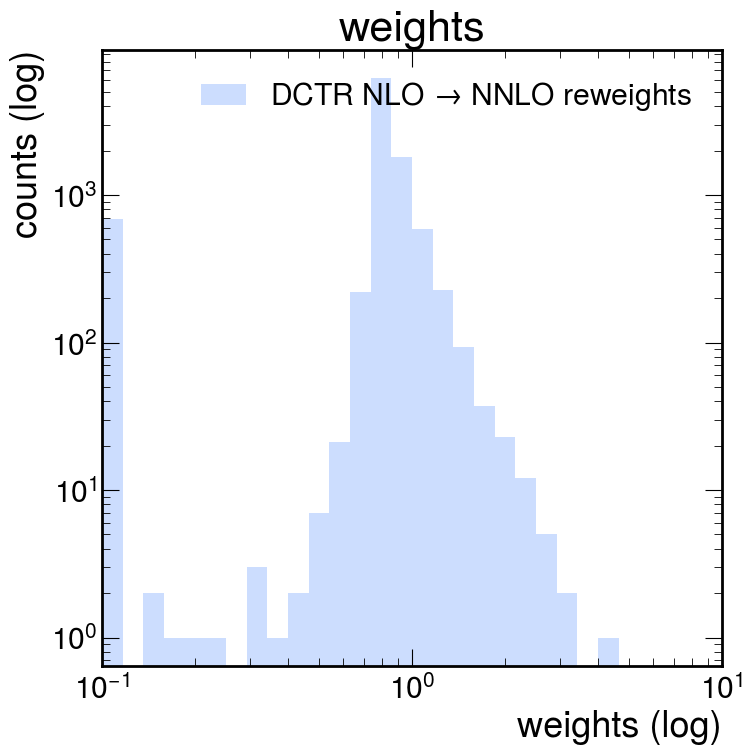

In [10]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta
# garbage collection after deleting to clear memory asap
print(gc.collect())

# calculate weights from DCTR
model = '../20240510_showered/train_20240512/super_epoch_7/run_2/s-7_b-131072_r-2.tf' # path to previously trained model (in .tf format (folder)) for showered events

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_wgt)


/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1382: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: divide by zero encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: divide by zero encountered in true_divide
  ratio_2 = hist2 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0


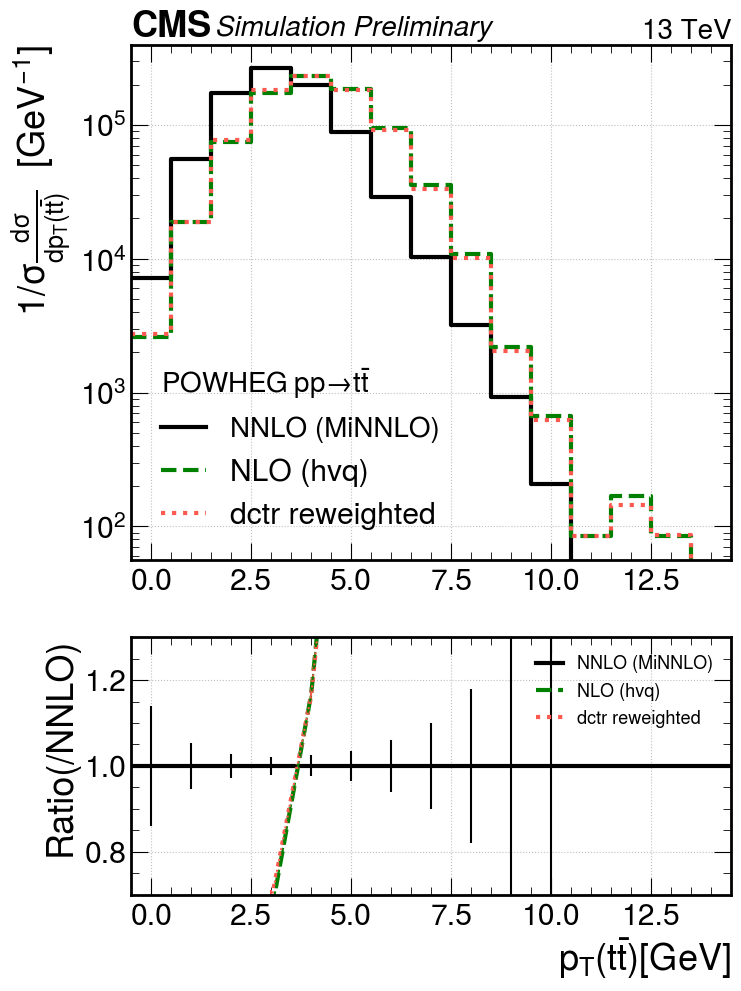

In [11]:
args_multiplicity = [(X1_nJets, X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nJets, X0_wgt, 'NLO (hvq)'),
                     (X0_nJets, rwgt, 'dctr reweighted')]


bins = np.linspace(-0.5, 14.5, 16)

DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], density = False)


np.shape(X0_jet) = (10000, 20, 6)
np.shape(X1_jet) = (10000, 20, 6)


/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1382: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0


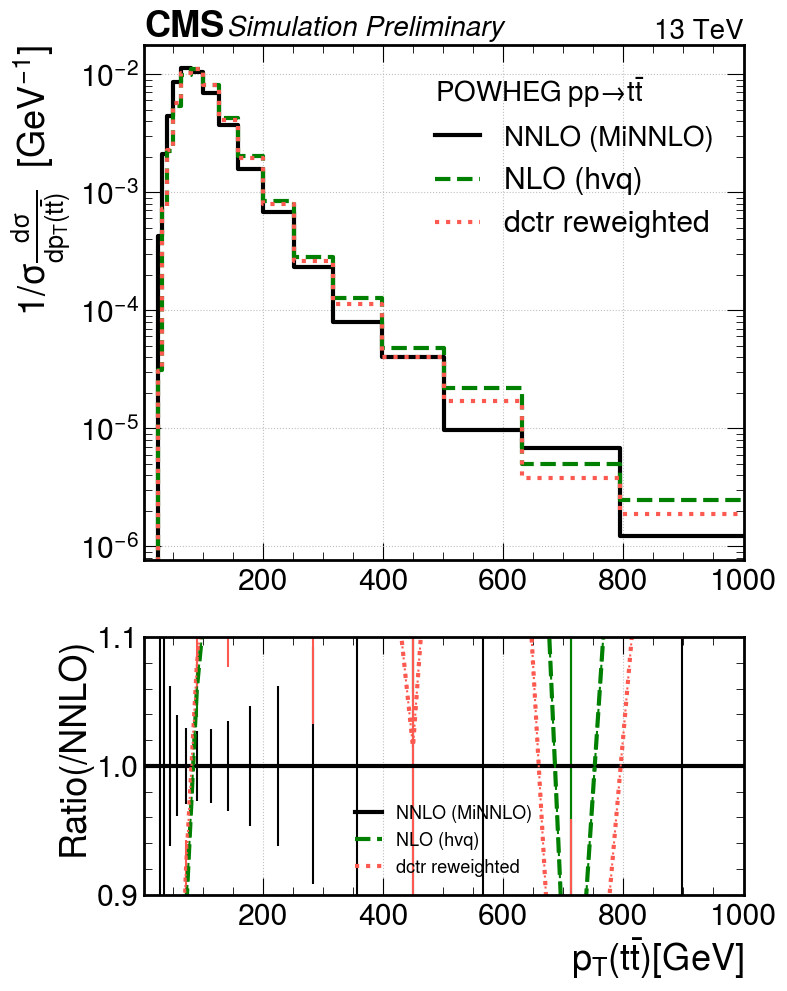

/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1382: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: divide by zero encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: divide by zero encountered in true_divide
  ratio_2 = hist2 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0


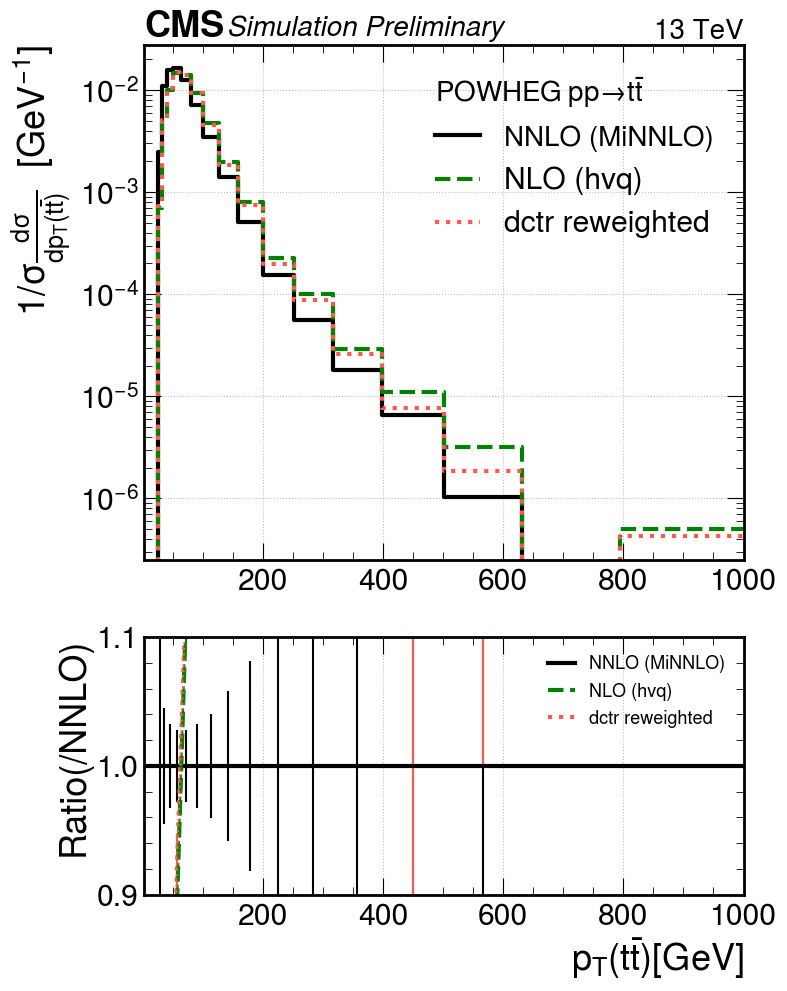

/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1382: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0


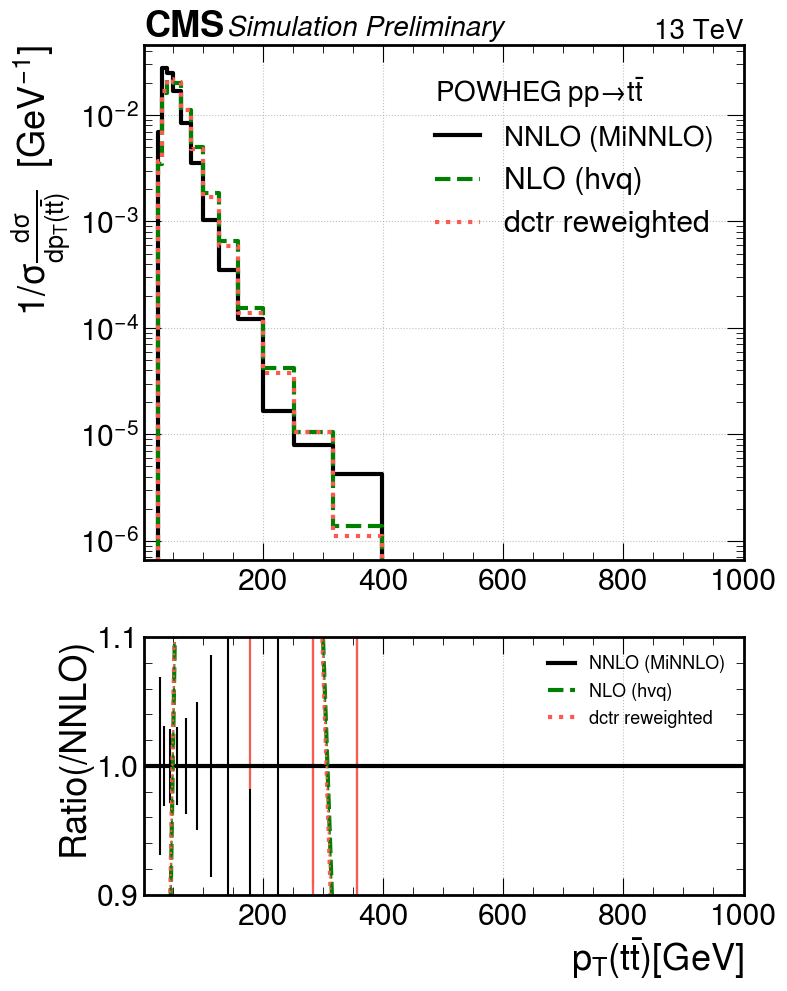

/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1382: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: divide by zero encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1383: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: divide by zero encountered in true_divide
  ratio_2 = hist2 / hist0
/tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240517_jets/../20240503/DCTR.py:1384: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0


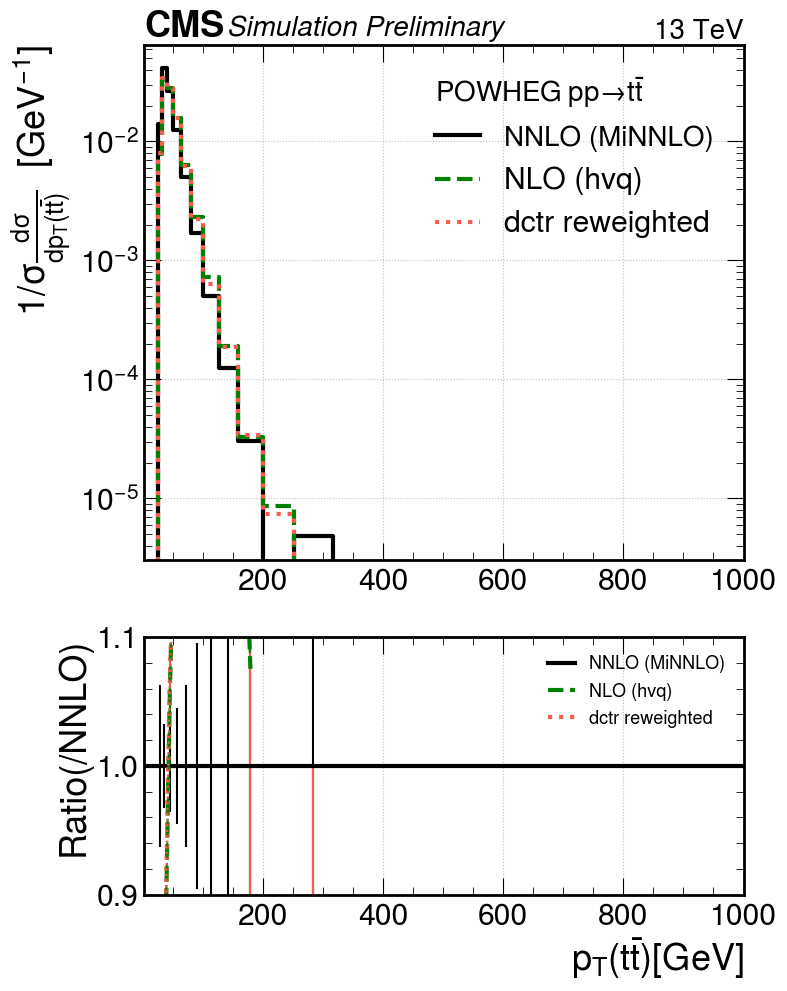

In [15]:
X0_jet = np.load('./jet_4vectors_hvq.npy')
X1_jet = np.load('./jet_4vectors_MiNNLO.npy')
print(f'{np.shape(X0_jet) = }')
print(f'{np.shape(X1_jet) = }')

log_bins = np.logspace(np.log10(1), np.log10(1000), 31)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log')


args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log')


args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log')


args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log')
